In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, optimize, stats
from observer import make_kfilter, vibe_fit_freq, get_psd, predict, update, noise_filter
from aberrations import make_1D_vibe_data, make_noisy_data

In [2]:
T = 1
f_sampling = 1000
steps = T * f_sampling
times = np.arange(0, steps/f_sampling, 1/f_sampling)

tt = np.load('keck_tt/OpenLoop_n0088.npy')[:1000,0]
tt_noisy = make_noisy_data(tt, 0.06)
commands = np.zeros(steps)
centroid = np.zeros(steps)

for i in range(steps):
    if i >= 4:
        commands[i-1] = 0.6*commands[i-2] + 0.32*commands[i-3] + 0.08*commands[i-4] + 0.1*centroid[i-1]
    centroid[i] = tt_noisy[i] - commands[i-1]

In [3]:
centroid_kalman = np.zeros(steps)

state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(tt_noisy)), N=10))
'''variances = [0.0011, 0.0009, 0.001, 0.0013, 0.0795, 0.0686, 0.0138, 0.1073, 0.027, 0.0035]
for i, v in enumerate(variances):
    Q[2*i][2*i] = v'''

states_freq = np.zeros((steps, state.size))
for k in range(steps):
    state, P = update(H, P, R, state, tt_noisy[k])
    states_freq[k] = state
    state, P = predict(A, P, Q, state)
    centroid_kalman[k] = tt_noisy[k] - H.dot(states_freq[k])
    
pos_freq = np.array([H.dot(state) for state in states_freq]).flatten()

/Users/adityasengupta/projects/adaptive-optics/control/dev/observer.py:69: RuntimeWarning: invalid value encountered in sqrt
  return A * np.exp(-k * 2 * np.pi * f * times) * np.cos(2 * np.pi * f * np.sqrt(1 - k**2) * times - p)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


In [4]:
settle = 4 # give it 4 frames for both the Kalman filter and the integrator to settle
error = lambda data: np.abs(data - tt)[settle:]
rms = lambda data: np.sqrt(np.mean(error(data)**2))
print("Average deviation in x, open loop: ", rms(tt_noisy))
print("Average deviation in x, standard integrator: ", rms(centroid))
print("Average deviation in x, Kalman filter: ", rms(pos_freq))

Average deviation in x, open loop:  0.0585918250577288
Average deviation in x, standard integrator:  0.0875360245660989
Average deviation in x, Kalman filter:  0.07836302140973833


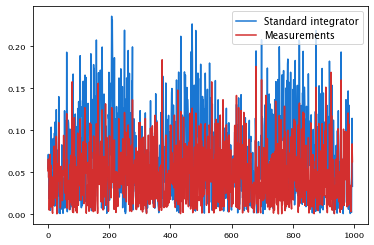

In [5]:
plt.plot(error(centroid), label='Standard integrator')
plt.plot(error(tt_noisy), label='Measurements')
plt.legend()